## Data, Libraries, set-up

In [35]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [36]:
import os
os.chdir("/content/drive/MyDrive/Diana Vieira Fernandes - Work folder/Qual A/Data")

In [37]:
os.environ["MOSEKLM_LICENSE_FILE"] = "/content/drive/MyDrive/Diana Vieira Fernandes - Work folder/Qual A/mosek.lic"

In [38]:
!ls "/content/drive/MyDrive/Diana Vieira Fernandes - Work folder/Qual A/Data"

'=10'
 100006-0.parquet
 8500node.zip
'8500node.zip (Unzipped Files)'
 9500-Node-Model-Submission-Model-Files.zip
'9500-Node-Model-Submission-Model-Files.zip (Unzipped Files)'
 annual_solar_value_by_plant_and_county_0.xlsx
 cluster_medians_com.csv
 cluster_medians.csv
 cluster_medians_solar.csv
 edges_list.csv
 European_LV_Test_Feeder_v2.zip
'European_LV_Test_Feeder_v2.zip (Unzipped Files)'
 feeder34.zip
'feeder34.zip (Unzipped Files)'
 GSA_Report_Pittsburgh.xlsx
 gwa-plot-data_2023-09-03169376876345007_19_23_UTC.zip
 IEEE34Node.zip
 median_loads_per_hour.csv
 metadata.tsv
 model.ilp
 monte_carlo_power_output_simulation.csv
 monte_carlo_simulation.csv
 network_44_WB.png
 network_80_WB.png
 network_graph.pgf
 networks_hour
'pa-pv-2006 .zip'
'pa-pv-2006 .zip (Unzipped Files)'
 pos_edges_list.csv
 slack_power_adjustments_p2p_trades.csv
 temp-plot.html
 up00-pjm-mediumoffice.csv
 up00-pjm-single-family_attached.csv
 up01-pa-mobile_home.csv
 your_problem.lp


In [6]:
!apt-get install -y graphviz libgraphviz-dev #data viz
!pip install pygraphviz diagrams # diagrams
!pip install pandapower["all"] #data
! pip install scipy
!pip install pandapower["all"] #data
!apt-get install -y -qq glpk-utils #solver
! pip install cplex #SDP
! pip install cvxpy[mosek] #(SDP/CP)
!apt-get install -y -qq coinor-cbc #interior poit method
! pip install gurobipy #gurobi (MILP)
! pip install scipy #transform .m to .pp
!pip install pydot graphviz # for HG
! pip install plotly #cute plots
! pip install numba #Need for PP pandapower

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
graphviz is already the newest version (2.42.2-6).
The following additional packages will be installed:
  libgail-common libgail18 libgtk2.0-0 libgtk2.0-bin libgtk2.0-common libgvc6-plugins-gtk
  librsvg2-common libxdot4
Suggested packages:
  gvfs
The following NEW packages will be installed:
  libgail-common libgail18 libgraphviz-dev libgtk2.0-0 libgtk2.0-bin libgtk2.0-common
  libgvc6-plugins-gtk librsvg2-common libxdot4
0 upgraded, 9 newly installed, 0 to remove and 24 not upgraded.
Need to get 2,433 kB of archives.
After this operation, 7,694 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 libgtk2.0-common all 2.24.33-2ubuntu2 [125 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/main amd64 libgtk2.0-0 amd64 2.24.33-2ubuntu2 [2,037 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/main amd64 libgail18 amd64 2.24.33-2ubuntu2 [15.9 kB]
Get:

In [7]:
import gurobipy as gp
# Create an environment with WLS license
params = {
"WLSACCESSID":'e83c1bc6-676d-4c3d-8bc2-0eb322fed75d',
"WLSSECRET":'96a3a8df-eefa-4bb0-9d82-13d1febddec3',
"LICENSEID":2433683,
}

env = gp.Env(params=params)

Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2433683
Academic license 2433683 - for non-commercial use only - registered to di___@andrew.cmu.edu


## Reading from already calculated clusters

In [10]:
import pandas as pd
cluster_medians_solar = pd.read_csv('/content/drive/MyDrive/Diana Vieira Fernandes - Work folder/Qual A/Data/cluster_medians_solar.csv', header=0, sep=',')
cluster_medians = pd.read_csv('/content/drive/MyDrive/Diana Vieira Fernandes - Work folder/Qual A/Data/cluster_medians.csv', header=0, sep=',')
cluster_medians_com = pd.read_csv('/content/drive/MyDrive/Diana Vieira Fernandes - Work folder/Qual A/Data/cluster_medians_com.csv', header=0, sep=',')

## Network

In [9]:
import pandapower as pp
import pandapower.networks as pn
from pandapower.plotting.plotly import vlevel_plotly

net = pn.create_cigre_network_lv()

#net = pp.networks.create_synthetic_voltage_control_lv_network(network_class='village_1')
net.name = "cigre network lv"
fig = vlevel_plotly(net)
fig.update_layout(width=800, height=600)
fig.show()

# Number of buses
n_buses = len(net.bus)

In [11]:
import pandapower as pp
import pandapower.networks as nw
import pandapower.plotting as plot
import networkx as nx
import numpy as np
from scipy.sparse import csr_matrix

# Create a graph from the network
graph = pp.topology.create_nxgraph(net)

# Remove all loads and generations
net.load.drop(net.load.index, inplace=True)
net.sgen.drop(net.sgen.index, inplace=True)
net.gen.drop(net.gen.index, inplace=True)

# Transpose the DataFrame
transposed_df = cluster_medians.T
# Take just the first row (hour 11 for now)
first_row = transposed_df.iloc[:, 11]
#Removing previous values
net.load.drop(net.load.index, inplace=True)

# Find extreme buses (logic is that loads and sgen will be here....)
extreme_buses = [node for node, degree in graph.degree() if degree == 1]
extreme_buses

# set loads on these
for bus in extreme_buses:
    #load = first_row.get(bus, 0)
    load = first_row.iloc[1]
    q_value = np.abs(load * np.tan(np.arccos(0.99)))
    pp.create_load(net, bus=bus, p_mw=load/1e3,q_mvar=q_value/1e3) #recall that values are in MW

# Calculate 50% of the extreme buses
num_to_add = int(len(extreme_buses) * 0.5)

# Randomly select 50% of the extreme buses
np.random.shuffle(extreme_buses)
selected_buses = extreme_buses[:num_to_add]

#Removing previous values
net.sgen.drop(net.sgen.index, inplace=True)

# Transpose the DataFrame for solar data
transposed_df_solar = cluster_medians_solar.T

# Take just the first row (hour 11 for now)
first_row_solar = transposed_df_solar.iloc[:, 11]

# Add sgens to the selected buses using solar data
for bus in selected_buses:
    #solar_value = first_row_solar[1] #1st cluster
    solar_value = first_row_solar.iloc[1]
    q_value = np.abs(solar_value * np.tan(np.arccos(0.99)))
    pp.create_sgen(net, bus=bus, p_mw=solar_value/1e3, q_mvar=q_value/1e3) #recall that values are in MW

In [12]:
# Run the power flow
pp.rundcpp(net, numba=False) #DC

Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)



In [13]:
#Ybus = net["_ppc"]['internal']['Ybus'].todense()
#print(Ybus.shape)

In [14]:
import copy

def update_network_for_hour(net, medians_df, median_solar_df, hour):
    transposed_loads_df = cluster_medians[['Cluster_0']]
    transposed_solar_df = cluster_medians_solar[['Cluster_0']]

    if hour >= len(transposed_loads_df) or hour >= len(transposed_solar_df):
        print("Hour index out of bounds.")
        return

    load_for_hour = transposed_loads_df.iloc[hour, 0]
    solar_for_hour = transposed_solar_df.iloc[hour, 0]

    net.load.drop(net.load.index, inplace=True)
    net.sgen.drop(net.sgen.index, inplace=True)

    graph = pp.topology.create_nxgraph(net)
    extreme_buses = [node for node, degree in graph.degree() if degree == 1]

    for bus in extreme_buses:
        load = load_for_hour  # Assuming each bus will have the same load for the hour
        q_value = np.abs(load * np.tan(np.arccos(0.99)))
        pp.create_load(net, bus=int(bus), p_mw=load/1e3, q_mvar=q_value/1e3)

    np.random.shuffle(extreme_buses)
    selected_buses = extreme_buses[:int(len(extreme_buses) * 0.5)] #50% with sgen

    for bus in selected_buses:
        solar_value = solar_for_hour  # Assuming each bus will have the same solar value for the hour
        q_value = np.abs(solar_value * np.tan(np.arccos(0.99)))
        pp.create_sgen(net, bus=bus, p_mw=solar_value/1e3, q_mvar=q_value/1e3)

# Initialize a list to store network states for each hour
all_nets = []

# Generate networks for each hour
for hour in range(24):
    # Create a deep copy of the network object for this hour
    net_copy = copy.deepcopy(net)

    # Update the network for the current hour
    update_network_for_hour(net_copy, cluster_medians, cluster_medians_solar, hour)

    # Store the network for this hour
    all_nets.append(net_copy)


## Elements (Ybus and Capacity)

## adjacency matrix

In [15]:
import numpy as np
import pandas as pd
import math


net_N = pn.create_cigre_network_lv()

# Remove all loads and generations to start with 1
net_N.load.drop(net_N.load.index, inplace=True)
net_N.sgen.drop(net_N.sgen.index, inplace=True)
net_N.gen.drop(net_N.gen.index, inplace=True)

# Run the power flow
pp.rundcpp(net_N ) #DC

# Initialize an empty adjacency matrix
n_buses = len(net_N.bus)
adj_matrix = np.zeros((n_buses, n_buses))

# Assume a default angle of 30 degrees in radians
delta_rad = math.radians(30)

# Loop over lines to populate adjacency matrix
for i, line in net_N.line.iterrows():
    from_bus = int(line.from_bus)
    to_bus = int(line.to_bus)
    reactance = line.x_ohm_per_km

    v_from = net_N.res_bus.vm_pu.loc[from_bus] * net_N.bus.vn_kv.loc[from_bus]
    v_to = net_N.res_bus.vm_pu.loc[to_bus] * net_N.bus.vn_kv.loc[to_bus]

    p_capacity = (v_from * v_to / reactance) * np.sin(delta_rad)

    adj_matrix[from_bus, to_bus] = p_capacity
    adj_matrix[to_bus, from_bus] = p_capacity

# Loop over transformers
for i, trafo in net_N.trafo.iterrows():
    hv_bus = int(trafo.hv_bus)
    lv_bus = int(trafo.lv_bus)
    sn_mva = trafo.sn_mva

    adj_matrix[hv_bus, lv_bus] = sn_mva
    adj_matrix[lv_bus, hv_bus] = sn_mva


# Loop over external grid connections
for i, eg in net_N.ext_grid.iterrows():
    bus = int(eg.bus)
    p_mw = eg.vm_pu * net_N.bus.vn_kv.loc[bus]

    if bus != 0:
        adj_matrix[0, bus] = p_mw
        adj_matrix[bus, 0] = p_mw

# Loop over switches
for i, switch in net_N.switch.iterrows():
    bus = int(switch.bus)
    element = int(switch.element)

    if switch.closed:
        if switch.et == 'l':  # Line switch
            P_capacity_switch = adj_matrix[bus, element]
        elif switch.et == 't':  # Transformer switch
            P_capacity_switch = adj_matrix[bus, element]
        elif switch.et == 'b':  # Bus switch
            P_capacity_switch = 0  # Set to zero or use your custom logic
    else:
        P_capacity_switch = 0  # Open switch

    adj_matrix[bus, element] = P_capacity_switch
    adj_matrix[element, bus] = P_capacity_switch

ext_grid_bus = net_N.ext_grid.bus.values[0]
s_sc_max_mva = net_N.ext_grid.s_sc_max_mva.values[0]  # Assuming this is the capacity for ext_grid
#s_sc_max_mva = 0

# Connect ext_grid to the transformers using capacity values
for i, hv_bus in enumerate(net_N.trafo.hv_bus.values):
    trafo_capacity = net_N.trafo.sn_mva.values[i]
    adj_matrix[ext_grid_bus, hv_bus] = min(s_sc_max_mva, trafo_capacity)
    adj_matrix[hv_bus, ext_grid_bus] = min(s_sc_max_mva, trafo_capacity)


# Convert to DataFrame
adj_matrix_df = pd.DataFrame(adj_matrix)

Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)



In [16]:
adj_matrix_array = adj_matrix_df.to_numpy()

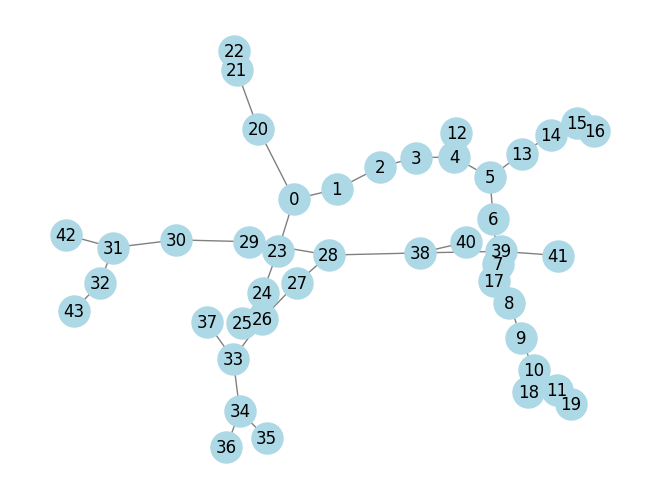

In [17]:
import networkx as nx

from matplotlib import pyplot as plt

# Create graph
G = nx.Graph(adj_matrix_array)

# Plot graph
nx.draw(G, with_labels=True, node_color='lightblue', node_size=500, edge_color='gray')
plt.show()

In [18]:
import pandapower as pp
import plotly.graph_objects as go
import pandapower.networks as nw
import networkx as nx
import matplotlib.pyplot as plt
from networkx.drawing.nx_pydot import graphviz_layout
import pygraphviz as pgv

# Create graph
G = nx.Graph(adj_matrix_array)

# Extract the edges from the pandapower graph
edges_from_graph = list(G.edges())

# Create a new directed graph (DiGraph)
G = nx.DiGraph()

# Add the edges to make it hierarchical
G.add_edges_from(edges_from_graph)

pos = graphviz_layout(G, prog="dot")

pos_df = pd.DataFrame(list(pos.values()), columns=['X', 'Y'])
pos_df['Node'] = pos.keys()

# Modify node colors

# Remove selected buses from extreme_buses (this was calculate before to assign node, where loads to all with degree less than 1, then 50% get sgen)
extreme_buses_1 = [bus_id for bus_id in extreme_buses if bus_id not in selected_buses]

# Create a dictionary to specify colors for the nodes
node_colors = {node: 'red' if node == 0 else 'green' if node in extreme_buses_1 else 'orange' if node in selected_buses else 'grey' for node in net.bus.index}

# edge colors
edge_colors = {
    (0, 1): 'red',
    (0, 2): 'black',
    (0, 23): 'red',
    (0, 20): 'red'
}


# Create a figure with a white background
fig = plt.figure(figsize=(10, 8), facecolor='white')

fig = go.Figure()

# Loop through nodes and add them to the plot, set showlegend to False
for node in G.nodes:
    x, y = pos[node]
    color = node_colors.get(node, 'grey')
    fig.add_trace(go.Scatter(x=[x], y=[y], mode='markers',
                             marker=dict(size=10, color=color),
                             text=str(node), showlegend=False))

# Loop through edges and add them to the plot, set showlegend to False
for lv_bus, hv_bus in G.edges:
    x1, y1 = pos[lv_bus]
    x2, y2 = pos[hv_bus]
    color = edge_colors.get((lv_bus, hv_bus), 'black')
    fig.add_trace(go.Scatter(x=[x1, x2], y=[y1, y2], mode='lines',
                             line=dict(width=2, color=color), showlegend=False))
# Add legend with colors
legend_colors = {
    'Bus 0 (Slack)': 'red',
    'Consumers': 'green',
    'Prosumers': 'orange',
    'iddle': 'grey'
}

# legend with colors, attribute set to True
for label, color in legend_colors.items():
    fig.add_trace(go.Scatter(x=[None], y=[None], mode='markers',
                             marker=dict(size=10, color=color),
                             name=label, showlegend=True))


#layout
fig.update_layout(width=800, height=600, plot_bgcolor='white',
                  showlegend=True, legend=dict(orientation='h', x=0, y=1.1),
                  xaxis_visible=False, yaxis_visible=False,
                  font=dict(
                      family="'CMU Serif', serif",  # This is a font resembles LaTeX font
                      size=18,
                      color="black"
    ))

fig.update_yaxes(scaleanchor='x', scaleratio=0.5)

# Show the plot
fig.show()

# Save to CSV
pos_df.to_csv('pos_edges_list.csv', index=False)
# Convert edges_from_graph to a DataFrame
edges_df = pd.DataFrame(edges_from_graph, columns=['Source', 'Target'])

# Save the DataFrame to a CSV file
edges_df.to_csv('edges_list.csv', index=False)

<ipython-input-18-825a0afa3119>:21: DeprecationWarning:

nx.nx_pydot.graphviz_layout depends on the pydot package, which has known issues and is not actively maintained. Consider using nx.nx_agraph.graphviz_layout instead.

See https://github.com/networkx/networkx/issues/5723



<Figure size 1000x800 with 0 Axes>

## Fixing Ybus

In [19]:
net_N["_ppc"]['internal']['Ybus']

orphaned_buses = set(net_N.bus.index) - set(net_N.line.from_bus) - set(net_N.line.to_bus) - set(net_N.trafo.hv_bus) - set(net_N.trafo.lv_bus)
if orphaned_buses:
    print(f"Orphaned buses detected: {orphaned_buses}")

print(net_N.ext_grid)

connected_lines = net_N.line[(net_N.line.from_bus == 0) | (net_N.line.to_bus == 0)]
print(connected_lines)

connected_trafos = net_N.trafo[(net_N.trafo.hv_bus == 0) | (net_N.trafo.lv_bus == 0)]
print(connected_trafos)

pp.create_ext_grid(net_N, bus=0, vm_pu=1.0, name="Grid Connection")
bus_hv = 0  # This is the bus where the external grid is connected.
#bus_lv = pp.create_bus(net, vn_kv=20.0, name="LV Bus")
#pp.create_transformer(net, hv_bus=bus_hv, lv_bus=bus_lv, std_type="25 MVA 110/20 kV", name="T1")

from pandapower.pypower.makeYbus import makeYbus
Ybus1, Yf, Yt = makeYbus(net_N._ppc['baseMVA'], net_N._ppc['bus'], net_N._ppc['branch'])
Ybus_dense_check = Ybus1.todense()
print(Ybus_dense_check.shape)

Orphaned buses detected: {0}
   name  bus  vm_pu  va_degree  slack_weight  in_service  s_sc_max_mva  \
0  None    0    1.0        0.0           1.0        True         100.0   

   s_sc_min_mva  rx_min  rx_max  
0         100.0     1.0     1.0  
Empty DataFrame
Columns: [name, std_type, from_bus, to_bus, length_km, r_ohm_per_km, x_ohm_per_km, c_nf_per_km, g_us_per_km, max_i_ka, df, parallel, type, in_service]
Index: []
Empty DataFrame
Columns: [name, std_type, hv_bus, lv_bus, sn_mva, vn_hv_kv, vn_lv_kv, vk_percent, vkr_percent, pfe_kw, i0_percent, shift_degree, tap_side, tap_neutral, tap_min, tap_max, tap_step_percent, tap_step_degree, tap_pos, tap_phase_shifter, parallel, df, in_service]
Index: []
(44, 44)


In [20]:
import numpy as np

# Initialize Ybus as a zeros matrix
Ybus = np.zeros((n_buses,n_buses), dtype=complex)

# Iterate over lines in the network
for _, line in net_N.line.iterrows():
    # Get the from and to buses
    from_bus = int(line.from_bus)
    to_bus = int(line.to_bus)

    # Calculate the line admittance
    z = complex(line.r_ohm_per_km, line.x_ohm_per_km)  # r and x are given per km
    y = 1 / z

    # Populate the Ybus matrix
    Ybus[from_bus][from_bus] += y
    Ybus[to_bus][to_bus] += y
    Ybus[from_bus][to_bus] -= y
    Ybus[to_bus][from_bus] -= y

# Include switches (assumed open)
for _, switch in net_N.switch.iterrows():
    bus = int(switch.bus)
    Ybus[bus][bus] += 1e-6  # Small admittance to represent open switch

# Include external grid (slack bus)
slack_bus = 0
Ybus[slack_bus][slack_bus] += 1e6  # Large admittance to represent external grid

# Include transformers (equivalent pi-model)
for _, trafo in net_N.trafo.iterrows():
    hv_bus = int(trafo.hv_bus)
    lv_bus = int(trafo.lv_bus)


    # Manually specify transformer parameters in per unit values
    vk_percent = trafo.vk_percent
    vkr_percent = trafo.vkr_percent

    # Calculate series and shunt admittances
    z_series = complex(0, vkr_percent / 100 * vk_percent / 100)  # Assuming vk_percent and vkr_percent are given in per unit
    y_series = 1 / z_series

    # Populate the Ybus matrix
    Ybus[hv_bus][hv_bus] += y_series
    Ybus[lv_bus][lv_bus] += y_series
    Ybus[hv_bus][lv_bus] -= y_series
    Ybus[lv_bus][hv_bus] -= y_series

print(Ybus)

[[1.00000000e+06+0.00000000e+00j 0.00000000e+00+0.00000000e+00j
  0.00000000e+00+0.00000000e+00j ... 0.00000000e+00+0.00000000e+00j
  0.00000000e+00+0.00000000e+00j 0.00000000e+00+0.00000000e+00j]
 [0.00000000e+00+0.00000000e+00j 0.00000000e+00-2.42535603e+03j
  0.00000000e+00+2.42535603e+03j ... 0.00000000e+00+0.00000000e+00j
  0.00000000e+00+0.00000000e+00j 0.00000000e+00+0.00000000e+00j]
 [0.00000000e+00+0.00000000e+00j 0.00000000e+00+2.42535603e+03j
  4.88448495e+00-2.42786461e+03j ... 0.00000000e+00+0.00000000e+00j
  0.00000000e+00+0.00000000e+00j 0.00000000e+00+0.00000000e+00j]
 ...
 [0.00000000e+00+0.00000000e+00j 0.00000000e+00+0.00000000e+00j
  0.00000000e+00+0.00000000e+00j ... 4.82598575e-01-7.99983655e-02j
  0.00000000e+00+0.00000000e+00j 0.00000000e+00+0.00000000e+00j]
 [0.00000000e+00+0.00000000e+00j 0.00000000e+00+0.00000000e+00j
  0.00000000e+00+0.00000000e+00j ... 0.00000000e+00+0.00000000e+00j
  4.82598575e-01-7.99983655e-02j 0.00000000e+00+0.00000000e+00j]
 [0.000000

## full 24 block process

In [34]:
## 1. Libraries and data

import pandas as pd
import numpy as np
import cvxpy as cp
import networkx as nx
import pandapower as pp
from copy import deepcopy
from gurobipy import Model, GRB, quicksum, LinExpr
import numpy as np
import time
from collections import defaultdict


adj_matrix = adj_matrix #Max line capacity
B = np.imag(Ybus1)  # Susceptance matrix from the imaginary part of Ybus
n_buses = B.shape[0]


# 2. Function to match orders

THRESHOLD = 1e-5

# Function to update the network for a specific hour
#this generates de simulation for each hour to do the matching, all nets is a list with network data for each hour
def update_network_for_hour(net, cluster_medians, cluster_medians_solar, hour): #takes network, clusters and hour)

    transposed_loads_df = cluster_medians[['Cluster_0']] #be carefull when comparing single time step with this
    transposed_solar_df = cluster_medians_solar[['Cluster_1']] #be carefull when comparing single time step with this

    # Check bounds
    if hour >= len(transposed_loads_df) or hour >= len(transposed_solar_df):
        print(f"Hour index {hour} out of bounds.")
        return

    # Access the row for the specific hour
    load_for_hour = transposed_loads_df.iloc[hour, 0]
    solar_for_hour = transposed_solar_df.iloc[hour, 0]

    net.load.drop(net.load.index, inplace=True)
    net.sgen.drop(net.sgen.index, inplace=True)

    graph = pp.topology.create_nxgraph(net)
    extreme_buses = [node for node, degree in graph.degree() if degree == 1]

    for bus in extreme_buses:
        load = load_for_hour  # Assuming each bus will have the same load for the hour
        q_value = np.abs(load * np.tan(np.arccos(0.99)))
        pp.create_load(net, bus=int(bus), p_mw=load/1e3, q_mvar=q_value/1e3)

    np.random.shuffle(extreme_buses)
    selected_buses = extreme_buses[:int(len(extreme_buses) * 0.5)]  # 50% with sgen

    for bus in selected_buses:
        solar_value = solar_for_hour  # Assuming each bus will have the same solar value for the hour
        q_value = np.abs(solar_value * np.tan(np.arccos(0.99)))
        pp.create_sgen(net, bus=bus, p_mw=solar_value/1e3, q_mvar=q_value/1e3)

    return net  # Return the updated network


# Create 24 different networks for each hour

all_nets = []  # List to store networks for each hour

# Generate networks for each hour
for hour in range(24):
    # Create a deep copy of the network object for this hour
    net_copy = deepcopy(net)

    # Update the network for the current hour
    update_network_for_hour(net_copy, cluster_medians, cluster_medians_solar, hour)

    # Store the network for this hour
    all_nets.append(net_copy)


def match_orders(net):
    # Initialize dictionaries to track total traded quantities
    load_traded = {node: 0 for node in net.load.bus.unique()}
    gen_traded = {node: 0 for node in net.sgen.bus.unique()}

    initial_gen_capacity = {node: capacity for node, capacity in zip(net.sgen.bus, net.sgen.p_mw)}
    initial_load_demand = {node: demand for node, demand in zip(net.load.bus, net.load.p_mw)}

    # Set fixed prices for buyers and sellers
    fixed_ask_price = 0.2  # Fixed price for buyers
    net.load['ask_price'] = fixed_ask_price
    fixed_bid_price = 0.05  # Fixed price for sellers
    net.sgen['bid_price'] = fixed_bid_price

    # Create buy_orders and sell_orders DataFrames
    buy_orders = pd.DataFrame({
        'node': net.load.bus,
        'price': net.load.ask_price,
        'quantity': net.load.p_mw
    })

    sell_orders = pd.DataFrame({
        'node': net.sgen.bus,
        'price': net.sgen.bid_price,
        'quantity': net.sgen.p_mw
    })

    # Sort the buy and sell orders
    buy_orders = buy_orders.sort_values(by='price')
    sell_orders = sell_orders.sort_values(by='price', ascending=False)

    matches = []

    # Loop over each buy order
    for buy_idx, buy in buy_orders.iterrows():
        if buy['quantity'] <= 0 or initial_load_demand[buy['node']] <= 0:
            continue

        for sell_idx, sell in sell_orders.iterrows():
            if sell['quantity'] <= 0 or initial_gen_capacity[sell['node']] <= 0:
                continue

            if buy['price'] >= sell['price']:
                traded_quantity = min(buy['quantity'], sell['quantity'], initial_load_demand[buy['node']], initial_gen_capacity[sell['node']])
                matches.append((sell['node'], buy['node'], traded_quantity, sell['price']))

                buy_orders.at[buy_idx, 'quantity'] -= traded_quantity
                sell_orders.at[sell_idx, 'quantity'] -= traded_quantity
                initial_load_demand[buy['node']] -= traded_quantity
                initial_gen_capacity[sell['node']] -= traded_quantity

                if buy_orders.at[buy_idx, 'quantity'] == 0:
                    break

    # Remove orders with zero quantity
    buy_orders = buy_orders[buy_orders['quantity'] > 0]
    sell_orders = sell_orders[sell_orders['quantity'] > 0]

    #print("Matches:", matches)

    return matches

# Correcting baseline function (it is PF of everyone + whatever P2P) Network state without P2P
#def correct_baseline(all_nets):
#    for hour, net in enumerate(all_nets):
        # Apply match_orders to the network for this hour
        #matches_for_hour = match_orders(net)

        # Initialize dictionaries to track total traded quantities
        #gen_traded = {node: 0 for node in net.sgen.bus.unique()}
        #load_traded = {node: 0 for node in net.load.bus.unique()}

        # Aggregate traded quantities from matches
        #for source, destination, quantity, _ in matches_for_hour:
        #    gen_traded[source] += quantity
        #    load_traded[destination] += quantity

        # Update net.sgen with the total sold quantities
        #for node, quantity_sold in gen_traded.items():
        #    if node in net.sgen.bus.values:
        #        net.sgen.loc[net.sgen.bus == node, 'p_mw'] -= quantity_sold

        # Update net.load with the total bought quantities
        #for node, quantity_bought in load_traded.items():
        #    if node in net.load.bus.values:
        #        net.load.loc[net.load.bus == node, 'p_mw'] -= quantity_bought

        # Return the modified all_nets object
        #return all_nets


# 3. Function to run optimization for a specific hour


def run_optimization(net, B, adj_matrix, matches_hour):
    # Initialization

    n_trades = len(matches_hour) # Number of P2P trades
    max_angle_diff = np.pi / 6


    m = gp.Model("p2p_optimization", env=env)
    m.setParam('OutputFlag', 1)
    m.setParam("Method", 2) # Set Method to Interior Point (Barrier)
    m.setParam('Presolve', 0) #have to remove presolve otherwise will mess with updates and just remove all from the start


    # Decision variables
    theta = m.addVars(n_buses, lb=-GRB.INFINITY, ub=GRB.INFINITY, name="theta")
    slack_power = m.addVar(lb=-100, ub=100, name="slack_power")
    x = m.addVars(len(matches_hour), lb=0, ub=1, name="trade_vars")
    Pm = m.addVars(n_buses, lb=-GRB.INFINITY, ub=GRB.INFINITY, name="P") #need to add to get nodal power balance


    # Debugging the values in net.sgen and net.load (namely that did not erased before..)
    #print("Generation units in net.sgen:")
    #print(net.sgen)

    #print("\nLoad units in net.load:")
    #print(net.load)


    slack_bus_index = 0  # Define bus 0 as the slack bus
    total_power_mismatch = 0
    total_demand = 0
    total_gen = 0


    slack_bus_index = 0
    total_power_mismatch = 0
    total_demand = 0
    total_gen = 0

    for i in range(n_buses):
        sgen_indices = [t for t in net.sgen.index if net.sgen.at[t, 'bus'] == i]
        load_indices = [t for t in net.load.index if net.load.at[t, 'bus'] == i]

        generation_i = quicksum(net.sgen.at[t, 'p_mw'] for t in sgen_indices)
        demand_i = quicksum(net.load.at[t, 'p_mw'] for t in load_indices)


        # linear expressions for cumulative adjustments
        generation_adjustments = {i: LinExpr(0) for i in range(n_buses)}
        demand_adjustments = {i: LinExpr(0) for i in range(n_buses)}

        # Aggregate adjustments for each bus based on P2P trades
        for t, (source_bus, dest_bus, quantity, _) in enumerate(matches_hour):
            generation_adjustments[source_bus] += x[t] * quantity
            demand_adjustments[dest_bus] += x[t] * quantity

        # Debugging the values in net.sgen and net.load (namely that did not erased before..)
        #print("Generation units in net.sgen:")
        #print(net.sgen)

        #print("\nLoad units in net.load:")
        #print(net.load)

        # Add the adjustments from P2P trades
        #this is g_0 + tilde_g as was uptdated by tilde_g
        generation_i += generation_adjustments[i]
        demand_i += demand_adjustments[i]

        net_power_injection = generation_i - demand_i

        if i != slack_bus_index:
            total_power_mismatch += net_power_injection

        total_power_mismatch += net_power_injection

        total_demand += demand_i  # Increment total demand
        total_gen += generation_i  # Increment total mismatch

        power_flow_in_i = quicksum(B[i, j] * (theta[i] - theta[j]) for j in range(n_buses) if j != i)
        power_flow_out_i = quicksum(B[j, i] * (theta[j] - theta[i]) for j in range(n_buses) if j != i)


        # If the total mismatch is positive, the slack bus will absorb power (acts as load).
        # If the total mismatch is negative, the slack bus will supply power (acts as generator).
        m.addConstr(slack_power == total_power_mismatch, name="slack_power_balance")
        #m.update()


    #power_balance_constraints = {}
    # Apply power balance constraint for each bus
    #Pm = m.addVar(name="P") #to allow iteration
    Pm = m.addVars(n_buses, lb=-GRB.INFINITY, ub=GRB.INFINITY, name="P")
    #m.addConstr(net_power_injection + power_flow_out_i == - P_var, name=f"net_power_balance_{i}")
    #m.addConstr(P_var == net_power_injection - power_flow_out_i, name=f"net_power_balance_{i}")
    #power_balance_constraints[i] = m.addConstr(Pm[i] == net_power_injection - power_flow_out_i, name=f"power__{i}")
    #m.addConstr(Pm[i] == net_power_injection + power_flow_out_i, name=f"power_balance_{i}")

    m.addConstr(Pm[i] == net_power_injection + power_flow_out_i, name=f"power_balance_{i}")


    # If the total mismatch is positive, the slack bus will absorb power (acts as load).
    # If the total mismatch is negative, the slack bus will supply power (acts as generator).
    m.addConstr(slack_power == total_power_mismatch, name="slack_power_balance")

    # Angle difference constraints
    # Power flow constraints
    max_angle_diff = np.pi / 6  # 30 degrees
    for i in range(n_buses):
        for j in range(n_buses):
            if i != j and B[i, j] > 0: #connection between buses i and j
                power_flow = B[i, j] * (theta[i] - theta[j])
                m.addConstr(power_flow <= adj_matrix[i, j], name=f"P_flow_max_{i}_{j}")
                m.addConstr(power_flow >= -adj_matrix[i, j], name=f"P_flow_min_{i}_{j}")
                m.addConstr(theta[i] - theta[j] <= max_angle_diff, name=f"angle_diff_max_{i}_{j}")
                m.addConstr(theta[i] - theta[j] >= -max_angle_diff, name=f"angle_diff_min_{i}_{j}")

    # list to store the trade quantities
    trade_quantities = [quantity for _, _, quantity, _ in matches_hour]
    objective = quicksum(trade_quantities[t] * x[t] for t in range(len(matches_hour)))

    # Set the objective function in the model
    m.setObjective(objective, GRB.MAXIMIZE)


    # Callback function definition
    def data_cb(model, where):
        if where == GRB.Callback.BARRIER:
            cur_obj = model.cbGet(GRB.Callback.BARRIER_PRIMOBJ)
            runtime = time.time() - model._start
            model._data.append([runtime, cur_obj])
    m._obj = None
    m._bd = None
    m._data = []
    m._start = time.time()

    m.optimize(data_cb)
    m.printStats()


    if m.status == GRB.OPTIMAL or m.status == GRB.SUBOPTIMAL:

        print("Optimal solution found:")

        # Print theta values for each bus
        for i in range(n_buses):
            print(f"Bus {i} Theta: {theta[i].X:.6f}")

            # Print relax variable value for each bus
        for i in range(n_buses):
          print(f"Bus {i} relax: {Pm[i].X:.6f}")

        # Print trade execution levels (x[t]) along with associated quantities
        for t, (source_bus, dest_bus, quantity, _) in enumerate(matches_for_hour):
            executed_quantity = x[t].X * quantity
            print(f"Trade {t}: Execution level (x[{t}]): {x[t].X:.6f}, Quantity: {quantity}, Executed Quantity: {executed_quantity:.6f}")


      # Extracting the objective value of the optimization
        problem = m.ObjVal

        # Extracting the slack power value
        slack_power_value = slack_power.X

        # Extracting trade decisions and execution levels
        matched_trades = [(source_bus, dest_bus, x[t].X * quantity) for t, (source_bus, dest_bus, quantity, _) in enumerate(matches_hour)]

        # Extracting theta values
        theta_values = {i: theta[i].X for i in range(n_buses)}

        trade_execution_levels = [x[t].X for t in range(len(matches_hour))]

        # Create a list to store matched trades
        matched_trades = []

        print("\nTrade Decision for Each Trade with Each Bus:")
        # Loop over the trades
        for t, (source_bus, dest_bus, quantity, _) in enumerate(matches_for_hour):
            executed_quantity = x[t].X
            # Print details of the trade
            print(f"Trade {t} - Source Bus: {source_bus}, Dest Bus: {dest_bus}, Quantity: {quantity}, Executed Quantity: {executed_quantity:.6f}")
            trade_details = (t, source_bus, dest_bus, executed_quantity)
            matched_trades.append(trade_details)

        # Demand at each bus
        demand_at_bus = total_demand.getValue()
        total_demand_value = total_demand.getValue()
        print(f"Total Demand across all buses: {total_demand_value:.6f}")

    else:
        problem = None
        slack_power_value = None
        matched_trades = None
        theta_values = None
        trade_execution_levels = None
        trade_decisions = None
        demand_at_bus = None

    return problem, slack_power_value, matched_trades,theta_values,trade_execution_levels,demand_at_bus

all_matches = []

results = []

# Update all network states with P2P trades
#all_nets = correct_baseline(all_nets)

for hour, net in enumerate(all_nets):
    # Match orders for this hour's network
    matches_for_hour = match_orders(net)
    all_matches.append(matches_for_hour)

    # Filter out matches with negligible quantity
    matches_for_hour = [match for match in matches_for_hour if match[2] > THRESHOLD]

    # If no significant trades after filtering, skip optimization for this hour
    if not matches_for_hour:
        results.append(('No significant trades to optimize.', []))
        continue

    # Run optimization for this hour using the matches
    problem, slack_power_value, matched_trades, theta_values, trade_execution_levels, demand_at_bus = run_optimization(net, B, adj_matrix, matches_for_hour)
    results.append((problem, slack_power_value, matched_trades, theta_values, trade_execution_levels, demand_at_bus))

Set parameter Method to value 2
Set parameter Presolve to value 0
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (linux64 - "Ubuntu 22.04.3 LTS")

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Academic license 2433683 - for non-commercial use only - registered to di___@andrew.cmu.edu
Optimize a model with 366 rows, 139 columns and 778 nonzeros
Model fingerprint: 0x0dded359
Coefficient statistics:
  Matrix range     [2e-05, 1e+01]
  Objective range  [2e-05, 2e-05]
  Bounds range     [1e+00, 1e+02]
  RHS range        [2e-03, 1e+00]
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 131
 AA' NZ     : 5.341e+03
 Factor NZ  : 6.297e+03
 Factor Ops : 1.263e+05 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   5.64886365e+00  3.96428804e-02  1.89e+0

In [33]:
all_nets[11]

This pandapower network includes the following parameter tables:
   - bus (44 element)
   - load (13 element)
   - sgen (6 element)
   - switch (3 element)
   - ext_grid (1 elements)
   - line (37 element)
   - trafo (3 element)
   - bus_geodata (44 element)
 and the following results tables:
   - res_bus (44 element)
   - res_line (37 element)
   - res_trafo (3 element)
   - res_ext_grid (1 elements)
   - res_load (13 element)
   - res_sgen (6 element)
   - res_switch (3 element)

## Post processing

In [25]:
index_to_check = 11

# Extract relevant tuples from all_matches
load_tuples = all_matches[index_to_check]

for match in load_tuples:
    bus = match[1]
    expected_p_mw = match[2]

    # Find matching load in all_nets
    matching_load = all_nets[index_to_check].load[all_nets[index_to_check].load['bus'] == bus]['p_mw']

    if matching_load.empty:
        print(f"No match found for bus {bus} in all_nets[{index_to_check}].load")
    elif not np.isclose(matching_load.iloc[0], expected_p_mw, atol=1e-8):  # using numpy's isclose for floating point comparison
        print(f"Bus {bus}: Expected p_mw: {expected_p_mw}, Got from all_nets[{index_to_check}].load: {matching_load.iloc[0]}")


Bus 12.0: Expected p_mw: 0.0012150000000000002, Got from all_nets[11].load: 0.0024187854361715356
Bus 12.0: Expected p_mw: 0.0012037854361715355, Got from all_nets[11].load: 0.0024187854361715356
Bus 16.0: Expected p_mw: 1.1214563828464662e-05, Got from all_nets[11].load: 0.0024187854361715356
Bus 16.0: Expected p_mw: 0.0012150000000000002, Got from all_nets[11].load: 0.0024187854361715356
Bus 16.0: Expected p_mw: 0.0011925708723430708, Got from all_nets[11].load: 0.0024187854361715356
Bus 17.0: Expected p_mw: 2.2429127656929324e-05, Got from all_nets[11].load: 0.0024187854361715356
Bus 17.0: Expected p_mw: 0.0012150000000000002, Got from all_nets[11].load: 0.0024187854361715356
Bus 17.0: Expected p_mw: 0.0011813563085146062, Got from all_nets[11].load: 0.0024187854361715356
Bus 18.0: Expected p_mw: 3.3643691485393985e-05, Got from all_nets[11].load: 0.0024187854361715356


In [26]:
# Initializing lists to store extracted values for each hour
allowed_trade_quantities = []
count_allowed_trades = []
slack_power_adjustments = []
problem_values = []
matched_trades = []
theta_values = []
demand_at_buses_list = []

# Loop through results
for result in results:
    # Check if the result is empty
    if len(result) == 2:
        allowed_trade_quantities.append(0)
        count_allowed_trades.append(0)
        slack_power_adjustments.append(0)
        problem_values.append(0)
        matched_trades.append(0)
        theta_values.append(0)
        demand_at_buses_list.append(0)
    else:
        problem, slack_power_value, matched_trades_x, theta_values_x, trade_execution_levels_x, demand_at_bus_x = result

        # Calculate the required values for this hour
        allowed_quantity_for_hour = sum(trade[2] for trade in matched_trades_x if trade[2] > 0)
        count_allowed_for_hour = sum(1 for trade in matched_trades_x if trade[2] > 0)
        matched_trades_sum = sum(trade[2] for trade in matched_trades_x)
        #total_load_for_hour = sum(demand_at_bus_x.values())

        # Append to the respective lists
        allowed_trade_quantities.append(allowed_quantity_for_hour)
        count_allowed_trades.append(count_allowed_for_hour)
        slack_power_adjustments.append(slack_power_value)
        problem_values.append(problem)
        matched_trades.append(matched_trades_sum)
        theta_values.append(theta_values_x)
        demand_at_buses_list.append(total_load_for_hour)


TypeError: ignored

In [ ]:
combined_list = list(zip(allowed_trade_quantities, count_allowed_trades, slack_power_adjustments, problem_values, demand_at_buses_list))

In [ ]:
from collections import OrderedDict

# Create an ordered dictionary to hold each index as a key
ordered_data = OrderedDict()

# Loop over the length of the lists to create a nested dictionary for each index
for i in range(len(allowed_trade_quantities)):
    ordered_data[i] = {
        'allowed_trade_quantities': allowed_trade_quantities[i],
        'count_allowed_trades': count_allowed_trades[i],
        'slack_power_adjustments': slack_power_adjustments[i],
        'problem_values': problem_values[i],
        'demand_at_buses_list': demand_at_buses_list[i]
    }


In [ ]:
df = pd.DataFrame.from_dict(ordered_data, orient='index')
#df['P2P'] = 0.05
#df['grid'] = 0.2
df['Grid(non P2P)'] = df['demand_at_buses_list']
df['P2P'] = df['problem_values']
df['difference'] = df['demand_at_buses_list'] -  df['problem_values']
# Add the P2P and Grid (non-P2P) data to the DataFrame
df['Grid(non P2P)'] = df['slack_power_adjustments']
df['P2P'] = df['problem_values']

# Calculate % Load Fulfilled w/ P2P
df['% Load Fulfilled w/ P2P'] = (df['P2P'] / (df['P2P'] + df['Grid(non P2P)'])) * 100

# Replace NaN values with 0 (in case of division by zero)
df['% Load Fulfilled w/ P2P'] = df['% Load Fulfilled w/ P2P'].fillna(0)
df['benefit seller'] = 0.05 * df['P2P']
df['benefit buyer'] = 0.15 * df['P2P']

In [ ]:
import pandas as pd
from collections import OrderedDict

# Create an ordered dictionary from the lists
ordered_data = OrderedDict()
for i in range(len(allowed_trade_quantities)):
    ordered_data[i] = {
        'allowed_trade_quantities': allowed_trade_quantities[i],
        'count_allowed_trades': count_allowed_trades[i],
        'slack_power_adjustments': slack_power_adjustments[i],
        'problem_values': problem_values[i],
        'demand_at_buses_list': demand_at_buses_list[i]
    }

# Convert to DataFrame
df = pd.DataFrame.from_dict(ordered_data, orient='index')


df['Grid(non P2P)'] = df['slack_power_adjustments']
df['P2P'] = df['problem_values']
df['difference'] = df['demand_at_buses_list'] - df['problem_values']
df['% Load Fulfilled w/ P2P'] = (df['P2P'] / (df['P2P'] + df['Grid(non P2P)'])).fillna(0) * 100
df['benefit seller'] = 0.05 * df['P2P']
df['benefit buyer'] = 0.15 * df['P2P']


In [ ]:
df

allowed_trade_quantities  count_allowed_trades  slack_power_adjustments  \
0                        0.0                     0                 0.000000   
1                        0.0                     0                 0.000000   
2                        0.0                     0                 0.000000   
3                        0.0                     0                 0.000000   
4                        0.0                     0                 0.000000   
5                        0.0                     0                 0.000000   
6                        0.0                     0                 0.000000   
7                       72.0                     6                -0.058550   
8                       72.0                     6                -0.057354   
9                       96.0                     7                -0.052156   
10                     118.0                     8                -0.049835   
11                     141.0                     9                -0.048308   
12                     141.0                     9                -0.046757   
13                     118.0                     8                -0.047074   
14                     117.0                     8                -0.051272   
15                      92.0                     7                -0.059726   
16                      72.0                     6                -0.071426   
17                       0.0                     0                 0.000000   
18                       0.0                     0                 0.000000   
19                       0.0                     0                 0.000000   
20                       0.0                     0                 0.000000   
21                       0.0                     0                 0.000000   
22                       0.0                     0                 0.000000   
23                       0.0                     0                 0.000000   

    problem_values  demand_at_buses_list  Grid(non P2P)       P2P  difference  \
0         0.000000               0.00000       0.000000  0.000000    0.000000   
1         0.000000               0.00000       0.000000  0.000000    0.000000   
2         0.000000               0.00000       0.000000  0.000000    0.000000   
3         0.000000               0.00000       0.000000  0.000000    0.000000   
4         0.000000               0.00000       0.000000  0.000000    0.000000   
5         0.000000               0.00000       0.000000  0.000000    0.000000   
6         0.000000               0.00000       0.000000  0.000000    0.000000   
7         0.000126               1.72503      -0.058550  0.000126    1.724904   
8         0.001392               1.72503      -0.057354  0.001392    1.723638   
9         0.004596               1.72503      -0.052156  0.004596    1.720434   
10        0.006156               1.72503      -0.049835  0.006156    1.718874   
11        0.007234               1.72503      -0.048308  0.007234    1.717797   
12        0.007111               1.72503      -0.046757  0.007111    1.717920   
13        0.006642               1.72503      -0.047074  0.006642    1.718388   
14        0.005448               1.72503      -0.051272  0.005448    1.719582   
15        0.003732               1.72503      -0.059726  0.003732    1.721298   
16        0.001746               1.72503      -0.071426  0.001746    1.723284   
17        0.000000               0.00000       0.000000  0.000000    0.000000   
18        0.000000               0.00000       0.000000  0.000000    0.000000   
19        0.000000               0.00000       0.000000  0.000000    0.000000   
20        0.000000               0.00000       0.000000  0.000000    0.000000   
21        0.000000               0.00000       0.000000  0.000000    0.000000   
22        0.000000               0.00000       0.000000  0.000000    0.000000   
23        0.000000               0.00000       0.000000  0.000000    0.000000   

  

## Plots

In [ ]:
#p_mw_values = [net.load.p_mw for net in all_nets]
total_p_mw_per_net = [net.load.p_mw.sum() for net in all_nets]
difference = [allowed_trade - total_p_mw for total_p_mw, allowed_trade in zip(total_p_mw_per_net, allowed_trade_quantities)]

In [ ]:
import plotly.graph_objects as go

# Allowed Trade Quantities for Each Hour
fig1 = go.Figure(data=[
    go.Scatter(x=list(range(len(allowed_trade_quantities))), y=allowed_trade_quantities, mode='lines+markers')
])
fig1.update_layout(
    title="Allowed Trade Quantities for Each Hour",
    xaxis_title="Hour",
    yaxis_title="Allowed Trade Quantity (MW)"
)
fig1.show()

# Count of Allowed Trades for Each Hour
fig2 = go.Figure(data=[
    go.Scatter(x=list(range(len(count_allowed_trades))), y=count_allowed_trades, mode='lines+markers')
])
fig2.update_layout(
    title="Count of Allowed Trades for Each Hour",
    xaxis_title="Hour",
    yaxis_title="Count of Allowed Trades"
)
fig2.show()

# Slack Bus Power Adjustments for Each Hour
fig3 = go.Figure(data=[
    go.Scatter(x=list(range(len(slack_power_adjustments))), y=slack_power_adjustments, mode='lines+markers')
])
fig3.update_layout(
    title="Slack Bus Power Adjustments for Each Hour",
    xaxis_title="Hour",
    yaxis_title="Slack Power Adjustment (MW)"
)
fig3.show()

# Problem Values for Each Hour
fig4 = go.Figure(data=[
     go.Scatter(x=list(range(len(total_p_mw_per_net))), y=total_p_mw_per_net, mode='lines+markers')
 ])
fig4.update_layout(
     title="Load for Each Hour",
    xaxis_title="Hour",
     yaxis_title="Problem Value"
)
fig4.show()

#Total Generation Values for Each Hour
fig5 = go.Figure(data=[
   go.Scatter(x=list(range(len(difference))), y=difference, mode='lines+markers')
])
fig5.update_layout(
    title="difference for Each Hour",
    xaxis_title="Hour",
    yaxis_title="Total Generation (MW)"
)
fig5.show()

# Total Load Values for Each Hour
fig6 = go.Figure(data=[
    go.Scatter(x=list(range(len(demand_at_buses_list))), y=demand_at_buses_list, mode='lines+markers')
])
fig6.update_layout(
    title="Total Load Values for Each Hour",
    xaxis_title="Hour",
    yaxis_title="Total Load (MW)"
)
fig6.show()


In [ ]:
# Combined plot
fig = go.Figure()

# Adding each plot
fig.add_trace(go.Scatter(x=list(range(len(allowed_trade_quantities))), y=allowed_trade_quantities, mode='lines+markers', name='Allowed Trade Quantities'))
#fig.add_trace(go.Scatter(x=list(range(len(slack_power_adjustments))), y=slack_power_adjustments, mode='lines+markers', name='Slack Bus Power Adjustments'))
fig.add_trace(go.Scatter(x=list(range(len(demand_at_buses_list))), y=demand_at_buses_list, mode='lines+markers', name='Total Load Values'))


fig.add_trace(go.Scatter(
    x=list(range(len(slack_power_adjustments))),
    y=[-x for x in slack_power_adjustments],  # Negating each value in the list
    mode='lines+markers',
    name='Inverted Slack Bus Power Adjustments'
))
# Update layout
fig.update_layout(
    title="Combined Chart for Different Metrics",
    xaxis_title="Hour",
    yaxis_title="Values"
)

# Show plot
fig.show()

In [ ]:
import plotly.graph_objects as go

# Invert the slack_power_adjustments
inverted_slack_power_adjustments = [-x for x in slack_power_adjustments]

inverted_slack_power_adjustments_all = [-x for x in difference]

# Calculate the top line of the stack
top_line_stack = [a + b for a, b in zip(inverted_slack_power_adjustments_all, allowed_trade_quantities)]

# Combined area plot
fig = go.Figure()

# First, add the inverted slack power adjustments as the bottom area
fig.add_trace(go.Scatter(
    x=list(range(len(inverted_slack_power_adjustments_all))),
    y=inverted_slack_power_adjustments_all,
    mode='lines',
    fill='tozeroy',
    name='Slack Bus Power Adjustments'
))

# Next, add the top line of the stack, filling down to the inverted slack power adjustments
fig.add_trace(go.Scatter(
    x=list(range(len(top_line_stack))),
    y=top_line_stack,
    mode='lines',
    fill='tonexty',
    name='P2P trades'
))


# Adding the demand at buses list as an area chart, stacked on the previous one
fig.add_trace(go.Scatter(
    x=list(range(len(total_p_mw_per_net))),
    y=total_p_mw_per_net,
    mode='lines',
    fill='tonexty',  # Fills to the next trace
    name='Total Load'
))


# Update legend and layout
fig.update_layout(
    title="Total P2P traded and slack adjustments per hour",
    xaxis_title="Hour",
    yaxis_title="MWh",
    font=dict(family="Times New Roman"),
    title_x=0.5,
    legend=dict(orientation="h", x=1, y=1.1, xanchor="right")
)



fig.update_layout(
    width=1000,
    height=600
)

# Show plot
fig.show()


In [ ]:
data = {
    'Hour': list(range(len(slack_power_adjustments))),
    'Inverted Slack Power Adjustments': inverted_slack_power_adjustments_all,
    'Top Line of Stack (P2P trades)': top_line_stack,
    'Total Load (MWh)': total_p_mw_per_net
}

df = pd.DataFrame(data)

# Save the DataFrame to a CSV file
csv_file_path = 'slack_power_adjustments_p2p_trades.csv'
df.to_csv(csv_file_path, index=False)

print(f"Data saved to {csv_file_path}")

Data saved to slack_power_adjustments_p2p_trades.csv


# update Sgen and Loads

In [ ]:
def update_generation_and_load_from_trades(net, trades_for_hour, matches_for_hour):
    for trade in trades_for_hour:
        bus_index, trade_data = trade
        for trade_index, trade_quantity in trade_data:
            # Only update if the trade quantity is positive
            if trade_quantity > 0:
                sell_bus, buy_bus, _, _ = matches_for_hour[trade_index - 1]  # Retrieve the matched trade

                # Update generation (sgen) for the selling node
                existing_sgen = net.sgen[net.sgen.bus == sell_bus]
                if not existing_sgen.empty:
                    sgen_index = existing_sgen.index[0]
                    net.sgen.at[sgen_index, 'p_mw'] += trade_quantity
                else:
                    pp.create_sgen(net, bus=sell_bus, p_mw=trade_quantity)

                # Update load for the buying node
                existing_load = net.load[net.load.bus == buy_bus]
                if not existing_load.empty:
                    load_index = existing_load.index[0]
                    net.load.at[load_index, 'p_mw'] += trade_quantity
                else:
                    pp.create_load(net, bus=buy_bus, p_mw=trade_quantity)


In [ ]:
for t, trade in enumerate(formatted_matches):
    source_bus, dest_bus, trade_quantity = trade[0], trade[1], trade[2]
    executed_quantity = x[t].X * trade_quantity

    # Update generation at the source bus (if it's a generator)
    if source_bus in net.sgen['bus'].values:
        sgen_index = net.sgen.index[net.sgen['bus'] == source_bus][0]
        net.sgen.at[sgen_index, 'p_mw'] += executed_quantity

    # Update load at the destination bus
    if dest_bus in net.load['bus'].values:
        load_index = net.load.index[net.load['bus'] == dest_bus][0]
        net.load.at[load_index, 'p_mw'] += executed_quantity

    # Update generation at the destination bus (if it's a generator)
    if dest_bus in net.sgen['bus'].values:
        sgen_index = net.sgen.index[net.sgen['bus'] == dest_bus][0]
        net.sgen.at[sgen_index, 'p_mw'] -= executed_quantity

    # Update load at the source bus
    if source_bus in net.load['bus'].values:
        load_index = net.load.index[net.load['bus'] == source_bus][0]
        net.load.at[load_index, 'p_mw'] -= executed_quantity


In [ ]:
for idx, (net, result) in enumerate(zip(all_nets, results)):
    if len(result) == 5:  # To ensure there are enough values to unpack
        problem_value, total_generation_value, total_load_value, slack_power_value, trades_for_hour = result
    else:
        trades_for_hour = None

    if trades_for_hour:  # Only proceed if trades_for_hour is not None or empty
        matching_orders = all_matches[idx]
        update_generation_and_load_from_trades(net, trades_for_hour, matching_orders)

    # Run power flow
    pp.runpp(net)


Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)

Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)

Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)

Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)

Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)

Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)

Probably the exe

In [ ]:
all_nets[11].res_ext_grid

p_mw    q_mvar
0  0.024268  0.003523

In [ ]:
# 10. Verify results
for idx, net in enumerate(all_nets, 1):  # 'idx' will act as a counter, starting from 1.
    # Run power flow analysis for the current net
    pp.rundcpp(net)

    # Check convergence
    if not net.converged:
        print(f"Power flow did not converge for network at index {idx}!")
        continue

    # Inspect voltage magnitudes
    vm_pu = net.res_bus.vm_pu
    if any(vm_pu < 0.90) or any(vm_pu > 1.05):
        print(f"Voltage out of bounds in network at index {idx} with buses: {net.res_bus[vm_pu < 0.90].index.tolist() + net.res_bus[vm_pu > 1.1].index.tolist()}")

    # Inspect line loading percentages
    loading_percent = net.res_line.loading_percent
    if any(loading_percent > 100):
        print(f"Lines overloaded in network at index {idx}: {net.res_line[loading_percent > 100].index.tolist()}")


Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)

Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)

Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)

Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)

Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)

Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)

Probably the exe

In [ ]:
import matplotlib.pyplot as plt


for i, hourly_data in enumerate(results):
    # Check if the third and fourth elements are lists and contain data
    if len(hourly_data) >= 4 and all(isinstance(item, (list, tuple)) for item in hourly_data[2:4]):

        # Extract the bus IDs and quantities from the third element (index 2)
        bus_ids_3rd = [data[0] for data in hourly_data[2] if isinstance(data, (list, tuple))]
        quantities_3rd = [data[2] for data in hourly_data[2] if isinstance(data, (list, tuple))]

        # Extract the bus IDs and quantities from the fourth element (index 3)
        bus_ids_4th = [data[1] for data in hourly_data[3] if isinstance(data, (list, tuple))]
        quantities_4th = [data[3] for data in hourly_data[3] if isinstance(data, (list, tuple))]

        # Plot for the third element, if data is available
        if bus_ids_3rd and quantities_3rd:
            plt.figure()
            plt.bar(bus_ids_3rd, quantities_3rd)
            plt.title(f'Hour {i} - Third Element Plot')
            plt.xlabel('Bus ID')
            plt.ylabel('Quantity')
            plt.show()

        # Plot for the fourth element, if data is available
        if bus_ids_4th and quantities_4th:
            plt.figure()
            plt.bar(bus_ids_4th, quantities_4th)
            plt.title(f'Hour {i} - Fourth Element Plot')
            plt.xlabel('Bus ID')
            plt.ylabel('Quantity')
            plt.show()


In [ ]:
import matplotlib.pyplot as plt
import numpy as np


for i, hourly_data in enumerate(results):
    # Check if the third and fourth elements are lists and contain data
    if len(hourly_data) >= 4 and all(isinstance(item, (list, tuple)) for item in hourly_data[2:4]):

        # Extract the bus IDs and quantities from the third element (index 2)
        bus_ids_3rd = [data[0] for data in hourly_data[2] if isinstance(data, (list, tuple))]
        quantities_3rd = [data[2] for data in hourly_data[2] if isinstance(data, (list, tuple))]

        # Extract the bus IDs and quantities from the fourth element (index 3)
        bus_ids_4th = [data[1] for data in hourly_data[3] if isinstance(data, (list, tuple))]
        quantities_4th = [data[3] for data in hourly_data[3] if isinstance(data, (list, tuple))]

        # Get unique bus IDs and sort them
        all_bus_ids = sorted(set(bus_ids_3rd + bus_ids_4th))

        # Initialize quantities list with zeros for each bus ID
        quantities_3rd_plot = [0] * len(all_bus_ids)
        quantities_4th_plot = [0] * len(all_bus_ids)

        # Populate the quantities for the plot
        for bus_id, quantity in zip(bus_ids_3rd, quantities_3rd):
            index = all_bus_ids.index(bus_id)
            quantities_3rd_plot[index] = quantity

        for bus_id, quantity in zip(bus_ids_4th, quantities_4th):
            index = all_bus_ids.index(bus_id)
            quantities_4th_plot[index] = quantity

        # Plotting
        x = np.arange(len(all_bus_ids))  # the label locations
        width = 0.35  # the width of the bars

        fig, ax = plt.subplots()
        rects1 = ax.bar(x - width/2, quantities_3rd_plot, width, label='3rd Element')
        rects2 = ax.bar(x + width/2, quantities_4th_plot, width, label='4th Element')

        # Add some text for labels, title and custom x-axis tick labels, etc.
        ax.set_ylabel('Quantity')
        ax.set_title(f'Hour {i} - Quantity by Bus ID')
        ax.set_xticks(x)
        ax.set_xticklabels(all_bus_ids)
        ax.legend()


        fig.tight_layout()

        plt.show()


In [ ]:
# Extract total optimal values from results and multiply by 1000
total_optimal_values = [result[0] * 1000 for result in results]

# Display the total optimal values
for i, value in enumerate(total_optimal_values):
    print(f"Optimal value for all_nets[{i}]: {value}")


Optimal value for all_nets[0]: No significant trades to optimize.No significant trades to optimize.No significant trades to optimize.No significant trades to optimize.No significant trades to optimize.No significant trades to optimize.No significant trades to optimize.No significant trades to optimize.No significant trades to optimize.No significant trades to optimize.No significant trades to optimize.No significant trades to optimize.No significant trades to optimize.No significant trades to optimize.No significant trades to optimize.No significant trades to optimize.No significant trades to optimize.No significant trades to optimize.No significant trades to optimize.No significant trades to optimize.No significant trades to optimize.No significant trades to optimize.No significant trades to optimize.No significant trades to optimize.No significant trades to optimize.No significant trades to optimize.No significant trades to optimize.No significant trades to optimize.No significant tr

In [ ]:
# Extract total optimal values from results and multiply by 1000
total_optimal_values = [result[1] * 1000 for result in results]

# Display the total optimal values
for i, value in enumerate(total_optimal_values):
    print(f"Grid[{i}]: {value}")

Grid[0]: []
Grid[1]: []
Grid[2]: []
Grid[3]: []
Grid[4]: []
Grid[5]: []
Grid[6]: []
Grid[7]: -58.54995243106487
Grid[8]: -57.35435104894293
Grid[9]: -52.15570670230818
Grid[10]: -49.83521603489294
Grid[11]: -48.3084213404652
Grid[12]: -46.75687598628997
Grid[13]: -47.074275997459836
Grid[14]: -51.27167292360468
Grid[15]: -59.72560804030991
Grid[16]: -71.4264767886732
Grid[17]: []
Grid[18]: []
Grid[19]: []
Grid[20]: []
Grid[21]: []
Grid[22]: []
Grid[23]: []


In [ ]:
import copy

# Create a list to store the updated networks with new names
updated_nets = []

# Loop through all_matches and update the corresponding sgen elements in updated_nets
for matches, original_net in zip(all_matches, all_nets):  # Use all_nets, not updated_nets
    # Create a copy of the original network to avoid modifying it directly
    updated_net = copy.deepcopy(original_net)

    for match in matches:
        source_bus = int(match[0])  # Convert to an integer if it's a float
        trade_quantity = match[2]  # Quantity from the match

        # Check if there is an existing sgen at the source_bus
        existing_sgen = updated_net.sgen[updated_net.sgen.bus == source_bus]

        if not existing_sgen.empty:
            sgen_index = existing_sgen.index[0]
            updated_net.sgen.at[sgen_index, 'p_mw'] += trade_quantity  # Update with the specific trade quantity
        else:
            # Create a new sgen with the trade quantity
            pp.create_sgen(updated_net, bus=source_bus, p_mw=trade_quantity)

    # Append the updated network to the list
    updated_nets.append(updated_net)


In [ ]:
updated_nets[11].sgen

name  bus     p_mw    q_mvar  sn_mva  scaling  in_service type  \
0  None   36  0.00243  0.000173     NaN      1.0        True  wye   
1  None   35  0.00243  0.000173     NaN      1.0        True  wye   
2  None   18  0.00243  0.000173     NaN      1.0        True  wye   
3  None   41  0.00243  0.000173     NaN      1.0        True  wye   
4  None   42  0.00243  0.000173     NaN      1.0        True  wye   
5  None   17  0.00243  0.000173     NaN      1.0        True  wye   

   current_source  bid_price  
0            True       0.05  
1            True       0.05  
2            True       0.05  
3            True       0.05  
4            True       0.05  
5            True       0.05

In [ ]:
all_nets[11].sgen

name  bus      p_mw    q_mvar  sn_mva  scaling  in_service type  \
0  None   36  0.001215  0.000173     NaN      1.0        True  wye   
1  None   35  0.001215  0.000173     NaN      1.0        True  wye   
2  None   18  0.001215  0.000173     NaN      1.0        True  wye   
3  None   41  0.001215  0.000173     NaN      1.0        True  wye   
4  None   42  0.001215  0.000173     NaN      1.0        True  wye   
5  None   17  0.001215  0.000173     NaN      1.0        True  wye   

   current_source  bid_price  
0            True       0.05  
1            True       0.05  
2            True       0.05  
3            True       0.05  
4            True       0.05  
5            True       0.05